In [1]:
import sys
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
import ants
import os
import bigbadbrain as bbb
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage.filters import gaussian_filter1d
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d

from skimage.filters import threshold_triangle
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages')
import os
import statsmodels.api as sm
import cv2
import matplotlib.patches as mpatches
import psutil
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.colors import Normalize
import matplotlib.colors as mcolors
from matplotlib import colors

%matplotlib inline
plt.rcParams.update({'font.size': 20})

from sklearn.feature_extraction.image import grid_to_graph
from mpl_toolkits.axes_grid1 import ImageGrid
import json
from matplotlib.ticker import FuncFormatter

import nibabel as nib

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from scipy.cluster import hierarchy
import itertools
import random
import matplotlib as mpl
from matplotlib.pyplot import cm

from scipy.interpolate import UnivariateSpline
from sklearn.linear_model import LinearRegression
import matplotlib.patches as patches

from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV

from scipy.fftpack import fft,fftshift,ifft
from scipy import signal
import pickle
from tqdm import tqdm
from shutil import copyfile
import cv2
from scipy.ndimage.morphology import binary_erosion
from scipy.ndimage.morphology import binary_dilation

In [2]:
### Load Luke Mean ###
luke_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/20210310_luke_exp_thresh.nii"
res_luke_mean = (0.65,0.65,1)
luke_mean = np.asarray(nib.load(luke_path).get_data().squeeze(), dtype='float32')
luke_mean = luke_mean[:,:,::-1] #flipz
luke_mean = ants.from_numpy(luke_mean)
luke_mean.set_spacing(res_luke_mean)
luke_mean_lowres =  ants.resample_image(luke_mean,(256,128,49),use_voxels=True)

### Load JFRC2018 ###
fixed_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/JRC2018_FEMALE_38um_iso_16bit.nii"
res_JRC2018 = (0.38, 0.38, 0.38)
fixed = np.asarray(nib.load(fixed_path).get_data().squeeze(), dtype='float32')
fixed = ants.from_numpy(fixed)
fixed.set_spacing(res_JRC2018)
fixed_lowres = ants.resample_image(fixed,(2,2,2),use_voxels=False)

### Load Atlas ###
atlas_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/jfrc_2018_rois_improve_reorient_transformed.nii"
atlas = np.asarray(nib.load(atlas_path).get_data().squeeze(), dtype='float32')
atlas = ants.from_numpy(atlas)
atlas.set_spacing((.76,.76,.76))
atlas = ants.resample_image(atlas,(2,2,2),use_voxels=False)

In [4]:
### Load supervoxel labels ###
n_clusters = 2000
labels_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20201129_super_slices/cluster_labels.npy'
cluster_model_labels = np.load(labels_file)

In [5]:
###########################
### Create Notch Filter ###
###########################

fs = 50.0  # Sample frequency (Hz)
f0 = 1.8797  # Frequency to be removed from signal (Hz)
Q = 0.2  # Quality factor <---- IMPORTANT
w0 = f0/(fs/2)  # Normalized Frequency

# Design notch filter
b_notch, a_notch = signal.iirnotch(w0, Q)

# Frequency response
w, h = signal.freqz(b_notch, a_notch)

# Generate frequency axis
freq = w*fs/(2*np.pi)

# ##########################
# ### Apply notch filter ###
# ##########################

# outputSignal = signal.filtfilt(b_notch, a_notch, signal_corrupt)

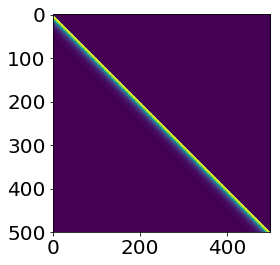

In [6]:
###########################################
### Create estimate of gcamp6f kinetics ###
###########################################

def fit_eq(x, a, b, c, d, e):
    return a*(1-np.exp(-x/b))*(c*np.exp(-x/d)) + e

x = np.arange(0, 50, 1)
y = fit_eq(x, 1, 4, -1, 8, 0)

filter_ = y*-1
filter_padded = np.pad(filter_, (0, 450), 'constant')

toe = scipy.linalg.toeplitz(filter_padded,r=[0]*500)
plt.imshow(toe)

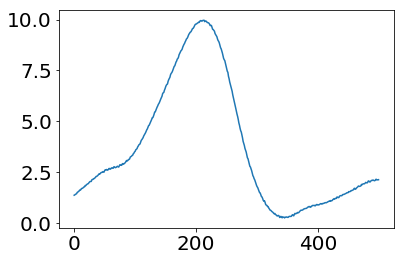

In [7]:
main_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210316_neural_weighted_behavior"
#main_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210316_neural_weighted_behavior/corrected"

response_files = [os.path.join(main_path, file) for file in os.listdir(main_path) if 'responses' in file]
bbb.sort_nicely(response_files)

responses = []
for file in response_files:
    responses.append(np.load(file))
responses = np.asarray(responses)

responses_split = np.reshape(responses, (49-18,2000,4,500))
responses_notch = signal.filtfilt(b_notch, a_notch, responses_split, axis=-1)

cluster_id = np.argmax(np.sum(responses_notch[20,:,0,:].real, axis=1))
plt.plot(responses_notch[20,cluster_id,0,:])

In [8]:
##################
### Deconvolve ###
##################

all_signals_unfiltered = np.reshape(responses_split[:,:,:,:],(31*2000,4,500))
all_signals = np.reshape(responses_notch,(31*2000,4,500))

all_signals_flipped = all_signals[:,:,::-1]
all_signals_deconv = []
for beh_idx in [0,1,2,3]:
    print(beh_idx)
    # flip filters in time
    temp = all_signals_flipped[:,beh_idx,:]

    # deconvolve
    deconv = np.linalg.lstsq(toe, temp.T)[0]
    deconv_smooth = gaussian_filter1d(deconv,sigma=3,axis=0)

    # Remove edge artifact
    deconv_smooth[:5,:] = deconv_smooth[5,:]
    deconv_smooth[-5:,:] = deconv_smooth[-5,:]

    # Flip back to being backwards in time
    deconv_smooth = deconv_smooth[::-1,:]
    all_signals_deconv.append(deconv_smooth)
all_signals_deconv = np.asarray(all_signals_deconv)
all_signals_deconv = np.swapaxes(all_signals_deconv,0,1)
all_signals_deconv = np.swapaxes(all_signals_deconv,0,2)

0
1
2
3


In [9]:
######################
### Get peaks, etc ###
######################

all_maxs = np.max(np.abs(all_signals_deconv),axis=-1)
thresholds = np.percentile(all_maxs,60,axis=0)

peaks = {}
peaks_ms = {}
peaks_unfiltered = {}
thresholded_filters_norm = {}
thresholded_filters_norm_unfiltered = {}
to_delete = {}
for beh_idx in [0,1,2,3]:
    print(beh_idx)
    to_delete_ = np.where(all_maxs[:,beh_idx]<thresholds[beh_idx])
    thresholded_filters = np.delete(all_signals_deconv[:,beh_idx,:], to_delete_, axis=0)
    
    # add gaussian smoothing
    thresholded_filters = gaussian_filter1d(thresholded_filters,sigma=2,axis=-1)
    
    peaks_ = np.argmax(thresholded_filters,axis=-1)
    #idx_sort = np.argsort(peaks)
    maxs = np.max(thresholded_filters,axis=-1)
    thresholded_filters_norm_ = thresholded_filters/maxs[:,np.newaxis]
    
    peaks[beh_idx] = peaks_
    peaks_ms[beh_idx] = (peaks_-250)*20
    thresholded_filters_norm[beh_idx] = thresholded_filters_norm_
    to_delete[beh_idx] = to_delete_
    
    thresholded_filters_unfiltered = np.delete(all_signals_unfiltered[:,beh_idx,:], to_delete_, axis=0)
    maxs = np.max(thresholded_filters_unfiltered,axis=-1)
    thresholded_filters_norm_ = thresholded_filters_unfiltered/maxs[:,np.newaxis]
    thresholded_filters_norm_unfiltered[beh_idx] = thresholded_filters_norm_
    
    peaks_ = np.argmax(thresholded_filters_unfiltered,axis=-1)
    peaks_unfiltered[beh_idx] = peaks_

0
1
2
3


In [73]:
peaks[0].shape

(24800,)

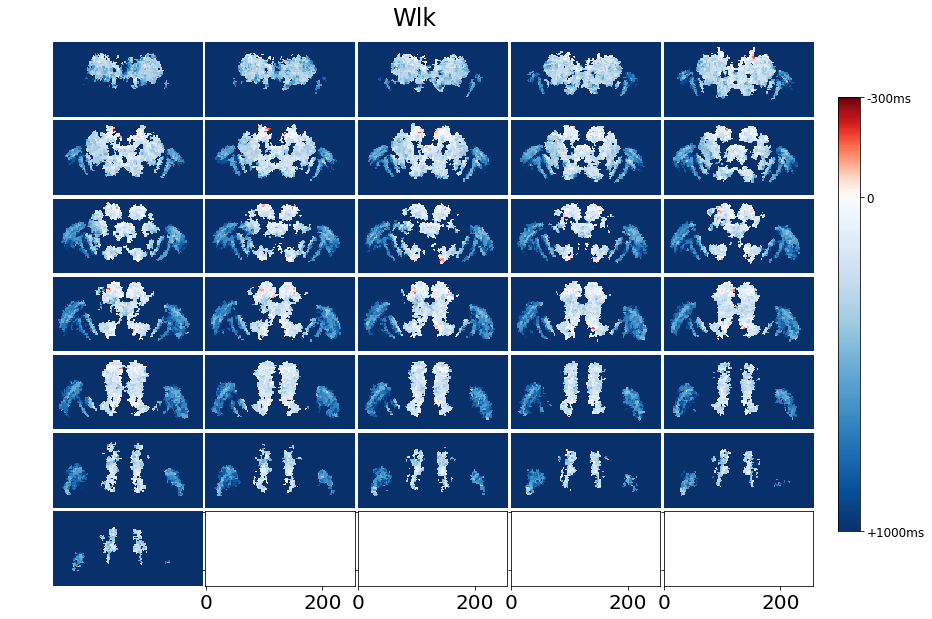

In [65]:
for beh_idx in [3]:
    behs = ['Vf', 'Vr+', 'Vr-', 'Wlk']

    add_deleted_voxels = np.zeros(62000)
    to_replace = [i for i in range(62000) if i not in to_delete[beh_idx][0]]
    add_deleted_voxels[to_replace] = peaks[beh_idx] #cluster_ids #model.labels_ ### put signal here
    to_plot = np.reshape(add_deleted_voxels, (31,2000))

    all_colored_by_betas = []
    for z in range(9,49-9):
        colored_by_betas = np.zeros(256*128)
        for cluster_num in range(len(np.unique(cluster_model_labels[z]))):
            cluster_indicies = np.where(cluster_model_labels[z]==cluster_num)[0]
            colored_by_betas[cluster_indicies] = to_plot[z-9,cluster_num]
        colored_by_betas = colored_by_betas.reshape(256,128)
        all_colored_by_betas.append(colored_by_betas)
    all_colored_by_betas = np.asarray(all_colored_by_betas)
    # to_plot = np.max(all_colored_by_betas, axis=0)
    # plt.imshow(to_plot[:,:].T)
    all_colored_by_betas[all_colored_by_betas==0] = 0 #np.nan #<--------------------

    start = 265
    end = 200
    middle = 250
    
#     start = 265
#     end = 235
#     middle = 250
    
#     start = 235
#     end = 190
    #middle = 250

    # sample the colormaps that you want to use. Use 128 from each so we get 256
    # colors in total
    colors1 = plt.cm.Blues_r(np.linspace(0., 1, middle-end))
    colors2 = plt.cm.Reds(np.linspace(0, 1, start-middle))

    # combine them and build a new colormap
    colors = np.vstack((colors1, colors2))
    mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)

    mymap.set_bad(color='grey')

    fig = plt.figure(figsize=(20,10))
    grid = ImageGrid(fig, 111, nrows_ncols=(7, 5), axes_pad=.05)
    for i in range(31):
        cax = grid[i].imshow(all_colored_by_betas[i,:,:].T,cmap=mymap,vmin=end,vmax=start);
        #cax = grid[i].imshow(all_colored_by_betas[i,:,:].T,cmap='jet',vmin=end,vmax=start);
        grid[i].axis('off')

    cbar = fig.colorbar(cax, ticks=[start, middle, end],shrink=.8, anchor=(.1,.5))
    cbar.ax.set_yticklabels(['-300ms', '0', '+1000ms'], fontsize=12)

#     cbar = fig.colorbar(cax, ticks=[start, end],shrink=.8, anchor=(.1,.5))
#     cbar.ax.set_yticklabels(['+300ms', '+1000ms'], fontsize=12)

    plt.suptitle(f'{behs[beh_idx]}',y=.93)

    save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
    timestr = time.strftime("%Y%m%d-%H%M%S")
    fname = os.path.join(save_path, f'{timestr}')
    #plt.savefig(fname,dpi=300,bbox_inches='tight')

In [13]:
all_colored_by_betas.shape

(31, 256, 128)

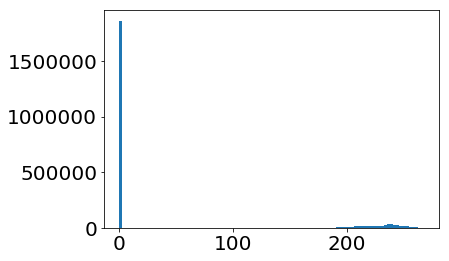

In [26]:
plt.hist(temporal_map.flatten(),bins=100);

In [66]:
pad = np.zeros((9,256,128))
all_colored_by_betas_full = np.concatenate((pad,all_colored_by_betas,pad))
all_colored_by_betas_full = np.moveaxis(all_colored_by_betas_full,0,2)
all_colored_by_betas_full.shape

(256, 128, 49)

In [67]:
moving = ants.from_numpy(all_colored_by_betas_full[:,:,::-1])
moving.set_spacing((2.6076, 2.6154, 5.3125)) ### matching this to the slightly off luke mean

In [68]:
out = ants.registration(fixed_lowres, luke_mean_lowres, type_of_transform='Affine')

In [69]:
maps_voxel_res = ants.apply_transforms(fixed_lowres, moving, out['fwdtransforms'][0], interpolator='nearestNeighbor')

In [70]:
temporal_map = maps_voxel_res.numpy()

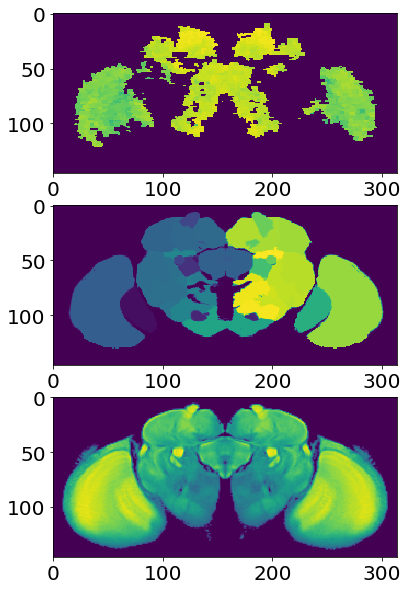

In [39]:
z=50
plt.figure(figsize=(10,10))
plt.subplot(311)
plt.imshow(temporal_map[:,:,z].T)
plt.subplot(312)
plt.imshow(atlas[:,:,z].T)
plt.subplot(313)
plt.imshow(out['warpedmovout'][:,:,z].T)

(-0.5, 313.5, 145.5, -0.5)

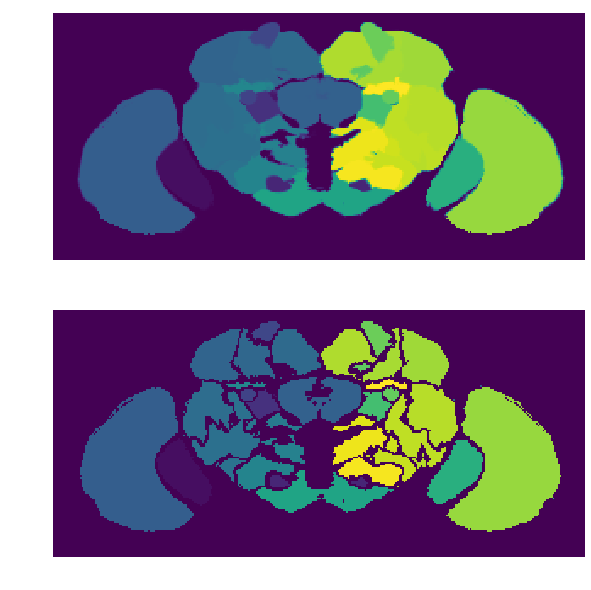

In [25]:
atlas = atlas.numpy()
atlas_int = np.rint(atlas)
atlas_clean = np.copy(atlas_int)
diff_atlas = atlas_int - atlas
thresh = 0.001
atlas_clean[np.where(np.abs(diff_atlas)>thresh)] = 0

plt.figure(figsize=(10,10))
plt.subplot(211)
plt.imshow(atlas[:,:,50].T)
plt.axis('off')

plt.subplot(212)
plt.imshow(atlas_clean[:,:,50].T)
plt.axis('off')

In [40]:
def plot_grouped_roi_image(rois,plot=True):
    roi_data = []
    roi_contours = []

    left_edges = []
    right_edges = []
    bottom_edges = []
    top_edges = []

    for roi in rois:
        ####################
        ### Get roi mask ###
        ####################

        mask = np.zeros(atlas_clean.shape)
        mask[np.where(atlas_clean == roi)] = 1

        mask_eroded = binary_erosion(mask, structure=np.ones((2,2,2)))
        mask_dilated = binary_dilation(mask_eroded, iterations=2)

        # temporal
        masked_roi = mask_dilated*temporal_map #CORR
        masked_roi_flat = np.max(masked_roi,axis=2)
        roi_data.append(masked_roi_flat)
        
        #PCA
#         masked_roi = mask_dilated*pca_map
#         maxs = np.max(masked_roi,axis=2)
#         mins = np.min(masked_roi,axis=2)
#         maxs[np.where(np.abs(mins)>maxs)] = mins[np.where(np.abs(mins)>maxs)]
#         masked_roi_flat = maxs
#         roi_data.append(masked_roi_flat)
    
        #######################
        ### Get roi contour ###
        #######################
        
        _, mask_binary = cv2.threshold(np.max(mask_dilated,axis=-1).astype('uint8'), 0, 1, cv2.THRESH_BINARY) 
        contours, _ = cv2.findContours(mask_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)#cv2.RETR_TREE

        canvas = np.ones(atlas_clean[:,:,0].shape)
        out = cv2.drawContours(canvas, contours, -1, (0,255,0), 1)
        out = np.abs(out-1) #flip 0/1
        roi_contour = np.repeat(out[:,:,np.newaxis],repeats=4,axis=-1) ### copy into rgba channels to make white
        roi_contours.append(roi_contour)

        # for plotting
        left_edges.append(np.where(np.sum(np.nan_to_num(roi_contour),axis=0)>0)[0][0])
        right_edges.append(np.where(np.sum(np.nan_to_num(roi_contour),axis=0)>0)[0][-1])
        top_edges.append(np.where(np.sum(np.nan_to_num(roi_contour),axis=1)>0)[0][0])
        bottom_edges.append(np.where(np.sum(np.nan_to_num(roi_contour),axis=1)>0)[0][-1])
        
    # get extreme edges from all rois used
    left_edge = np.min(left_edges) - 1
    right_edge = np.max(right_edges) + 1
    top_edge = np.min(top_edges) - 1
    bottom_edge = np.max(bottom_edges) + 1

    ############
    ### PLOT ###
    ############
    
    roi_datas = np.max(np.asarray(roi_data),axis=0)
    data_map = np.swapaxes(roi_datas[top_edge:bottom_edge,left_edge:right_edge],0,1)
    
    #PCA
#     roi_data = np.asarray(roi_data)
#     maxs = np.max(roi_data,axis=0)
#     mins = np.min(roi_data,axis=0)
#     maxs[np.where(np.abs(mins)>maxs)] = mins[np.where(np.abs(mins)>maxs)]
#     data_map = np.swapaxes(maxs[top_edge:bottom_edge,left_edge:right_edge],0,1)

    if plot:
        plt.figure(figsize=(10,10))
        plt.imshow(data_map)

    contours_to_export = []
    for i in range(len(roi_contours)):
        single_contour = np.swapaxes(roi_contours[i][top_edge:bottom_edge,left_edge:right_edge],0,1)
        contours_to_export.append(single_contour)
        if plot:
            plt.imshow(single_contour)
        
    return data_map, contours_to_export

def place_on_canvas(input_canvas, to_plot, is_contour=False, is_midline=True, x_shift=0, y_shift=0):
    full_y_mid = int(input_canvas.shape[0]/2)
    full_x_mid = int(input_canvas.shape[1]/2)

    y_mid = int(to_plot.shape[0]/2)
    x_mid = int(to_plot.shape[1]/2)

    height = to_plot.shape[0]
    width = to_plot.shape[1]

    left = full_x_mid-x_mid
    right = left + width

    top = full_y_mid-y_mid
    bottom = top + height

    if is_contour:
        ys = np.where(to_plot[:,:,0]>0)[0] + full_y_mid - y_mid + y_shift
        xs = np.where(to_plot[:,:,0]>0)[1] + full_x_mid - x_mid + x_shift
        input_canvas[ys,xs]=1
    else:
        #input_canvas[top+y_shift:bottom+y_shift,left+x_shift:right+x_shift,:3] = to_plot
        input_canvas[top+y_shift:bottom+y_shift,left+x_shift:right+x_shift] = to_plot #pca
    return input_canvas

def place_on_canvas_wrapper(canvas, data_map, contours, y_shift, x_shift):
    canvas = place_on_canvas(canvas, to_plot=data_map, y_shift=y_shift, x_shift=x_shift)
    for i in range(len(contours)):
        canvas = place_on_canvas(canvas, to_plot=contours[i], is_contour=True, y_shift=y_shift, x_shift=x_shift)
    return canvas

def wraper_wraper(canvas, roi_ids, y_shift, x_shift):
    data_map, contours = plot_grouped_roi_image(roi_ids, plot=False)
    canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)
    return canvas

In [41]:
##################
### ROI GROUPS ###
##################

FB_group = {
26: 'FB',
4: 'NO',
5: 'BU_R',
54: 'BU_L',
8: 'LAL_R',
56: 'LAL_L',
31: 'PVLP_R',
76: 'PVLP_L'}

ventromedial_r_group = {
13: 'VES_R',  
40: 'EPA_R',
35: 'GOR_R',
11: 'AMMC_R'}

ventromedial_l_group = {
60: 'VES_L', 
85: 'EPA_L',
80: 'GOR_L',
58: 'AMMC_L'}

PB = {6: 'PB'}
EB = {23: 'EB'}

anterior_group = {
50: 'PRW',
9: 'SAD',
49: 'GNG',
30: 'AVLP_R',
75: 'AVLP_L',
24: 'AL_R',
70: 'AL_L',
64: 'MB_PED_L',
65: 'MB_VL_L',
66: 'MB_ML_L',
81: 'MB_CA_L',
17: 'MB_PED_R',
18: 'MB_VL_R',
19: 'MB_ML_R',
36: 'MB_CA_R',
32: 'IVLP_R',
77: 'IVLP_L',
10: 'CAN_R',
20: 'FLA_R',
57: 'CAN_L',
67: 'FLA_L'}

big_r_group = {
27: 'SLP_R',
29: 'SMP_R',
33: 'PLP_R',
7: 'LH_R',
38: 'IPS_R',
37: 'SPS_R',
16: 'CRE_R',
39: 'SCL_R',
12: 'ICL_R',
15: 'ATL_R',
14: 'IB_R',
28: 'SIP_R'}
    
big_l_group = {
72: 'SLP_L',   
74: 'SMP_L',
78: 'PLP_L',
55: 'LH_L',
83: 'IPS_L',
82: 'SPS_L',
63: 'CRE_L',
84: 'SCL_L',  
59: 'ICL_L',
62: 'ATL_L',
61: 'IB_L',
73: 'SIP_L'}

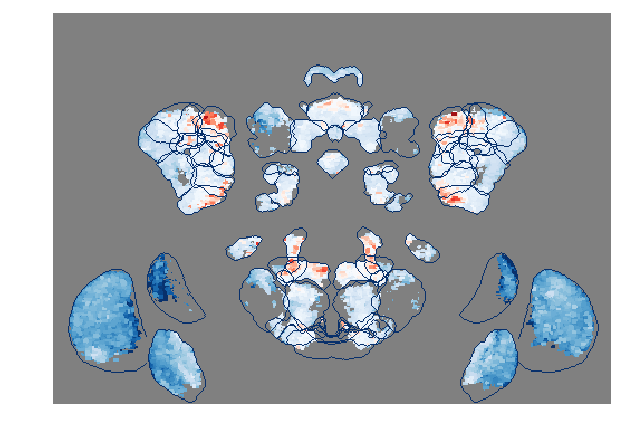

In [71]:
#input_canvas = np.zeros((500,500,3))
input_canvas = np.zeros((500,500)) #pca


x_shift=0; y_shift=0
data_map, contours = plot_grouped_roi_image(FB_group.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

x_shift=0; y_shift=-45
data_map, contours = plot_grouped_roi_image(PB.keys(), plot=False)
canvas = place_on_canvas_wrapper(canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

x_shift=0; y_shift=35
data_map, contours = plot_grouped_roi_image({23: 'EB'}.keys(), plot=False)
canvas = place_on_canvas_wrapper(canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

##########
### MB ###
##########

# x_shift=60; y_shift=-50
# data_map, contours = plot_grouped_roi_image(MB_left_group.keys(), plot=False)
# canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)
# x_shift=-60; y_shift=-50
# data_map, contours = plot_grouped_roi_image(MB_right_group.keys(), plot=False)
# canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

#################
### BIG GROUP ###
#################

x_shift=-130; y_shift=30
data_map, contours = plot_grouped_roi_image(big_r_group.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)
x_shift=130; y_shift=30
data_map, contours = plot_grouped_roi_image(big_l_group.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

##############
### VISUAL ###
##############

x_shift=-200; y_shift=175
data_map, contours = plot_grouped_roi_image({25: 'MED_R'}.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)
x_shift=200; y_shift=175
data_map, contours = plot_grouped_roi_image({71: 'MED_L'}.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

x_shift=-140; y_shift=40+175
data_map, contours = plot_grouped_roi_image({3: 'LO_R'}.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)
x_shift=140; y_shift=40+175
data_map, contours = plot_grouped_roi_image({53: 'LO_L'}.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

x_shift=-140; y_shift=-30+175
data_map, contours = plot_grouped_roi_image({22: 'LP_R'}.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)
x_shift=140; y_shift=-30+175
data_map, contours = plot_grouped_roi_image({69: 'LP_L'}.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

canvas = wraper_wraper(canvas, ventromedial_r_group.keys(), y_shift=55, x_shift=-50)
canvas = wraper_wraper(canvas, ventromedial_l_group.keys(), y_shift=55, x_shift=50)

canvas = wraper_wraper(canvas, anterior_group.keys(), y_shift=150, x_shift=0)

canvas = wraper_wraper(canvas, {34: 'AOTU_R'}.keys(), y_shift=-50+175-15, x_shift=-80)
canvas = wraper_wraper(canvas, {79: 'AOTU_L'}.keys(), y_shift=-50+175-15, x_shift=80)
    
canvas[np.where(canvas==0)] = np.nan

plt.figure(figsize=(10,10))
plt.imshow(canvas[150:,:],cmap=mymap,vmin=end,vmax=start)
plt.axis('off')

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}_wlk')
plt.savefig(fname,dpi=300,bbox_inches='tight')